In [15]:
%load_ext autoreload
%autoreload 2
import os
import sys
import importlib
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed
from itertools import product
from collections import defaultdict
import matplotlib.pyplot as plt

# 设定项目根目录
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### oral hypo list

In [12]:
import src.Bayesian_new.problems.model as model
importlib.reload(model)
from src.Bayesian_new.problems.model import SingleRationalModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_base

In [13]:
# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')

In [14]:
import src.Bayesian_recon.utils.oral_process as oral_process
importlib.reload(oral_process)
from src.Bayesian_recon.utils.oral_process import Oral_to_coordinate

# 初始化处理器
oral_to_coordinate = Oral_to_coordinate()

In [15]:
oral_hypos_list = {}

for _, subj_df in learning_data.groupby('iSub'):
    iSub   = int(subj_df['iSub'].iloc[0])
    cond   = int(subj_df['condition'].iloc[0])
    model  = SingleRationalModel(config_base, condition=cond)

    centres = subj_df[['feature1_oral','feature2_oral',
                       'feature3_oral','feature4_oral']].values
    choices = subj_df['choice'].values

    oral_hypos_list[iSub] = oral_to_coordinate.get_oral_hypos_list(cond,
        (centres, choices), model)

In [16]:
oral_hypo_hits = {}

for iSub, hypos in oral_hypos_list.items():
    condition = learning_data[learning_data['iSub'] ==
                                iSub]['condition'].iloc[0]
    target_value = 0 if condition == 1 else 42

    hits = []  # 用于存储每个 trial 的 hit 值
    for trial_hypos in hypos:
        if not trial_hypos:
            hits.append([])
        else:
            hits.append(1 if target_value in trial_hypos else 0)
            # 计算hits的16试次滑动平均
            numeric_hits = [h if isinstance(h, (int, float)) else 0 for h in hits]  # Convert non-numeric values to 0
            rolling_hits = pd.Series(numeric_hits).rolling(window=16, min_periods=16).mean().tolist()
            
    oral_hypo_hits[iSub] = {
        'iSub': iSub,
        'condition': condition,
        'hits': hits,
        'rolling_hits': rolling_hits
    }

In [ ]:
joblib.dump(oral_hypo_hits, Path(project_root) / 'results' / 'Bayesian_recon' / 'oral_hypo_hits.joblib')

['/home/yangjiong/CategoryLearning/results/Bayesian_recon/oral_hypo_hits.joblib']

#### model fitting

In [2]:
from src.Bayesian_recon import *
from src.Bayesian_recon.problems.config import config_fgt
from src.Bayesian_recon.problems import *
from src.Bayesian_recon.utils.optimizer import Optimizer

In [30]:
def post_acc_amount_f(x):
    if x <= 0.2:
        return 0
    elif 0.2 < x < 0.3:
        return 1
    elif 0.3 <= x < 0.4:
        return 2
    elif 0.4 <= x < 0.5:
        return 3
    elif 0.5 <= x < 0.6:
        return 4
    elif 0.6 <= x < 0.7:
        return 5
    elif 0.7 <= x < 0.8:
        return 6
    elif 0.8 <= x <= 1:
        return 7

def random_acc_amount_f(x):
    return 7 - post_acc_amount_f(x)


module_config = {
    "cluster": (PartitionCluster, {
        "transition_spec":
        [("random_4", "top_posterior"),
         ("opp_random_4", "random")]})
    ,
    "memory": (BaseMemory, {
        "personal_memory_range": {
            "gamma": (0.05, 1.0),
            "w0": (0.075, 0.15)
        },
        "param_resolution": 20
    })}
optimizer = Optimizer(module_config, n_jobs=120)

# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
optimizer.prepare_data(processed_path / 'Task2_processed.csv')

Error initializing module cluster: 'Optimizer' object has no attribute 'partition_model'


In [31]:
iSub = 1
results = optimizer.optimize_params_with_subs_parallel(
    config_fgt, [iSub], 16, 5, 1000)
    # list(range(1, 25))

Processing tasks:   0%|                                                     | 0/400 [00:00<?, ?it/s]

Computing error for params: 100%|██████████| 1000/1000 [00:09<00:00, 105.23it/s]


In [29]:
sub_results = results[iSub]
best_step_results = sub_results['best_step_results']
best_step_amounts = [step['best_step_amount'] for step in best_step_results if 'best_step_amount' in step]

In [ ]:
# 保存拟合结果
# result_path = Path(project_root) / 'results' / 'Bayesian_recon'
# os.makedirs(result_path, exist_ok=True)

# joblib.dump(results, result_path / 'M_fgt_cl.joblib')

['/home/yangjiong/CategoryLearning/results/Bayesian_recon/M_fgt_cl.joblib']

In [7]:
from src.Bayesian_recon.utils.model_evaluation import ModelEval
model_eval = ModelEval()

oral_hypo_hits = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'oral_hypo_hits.joblib')

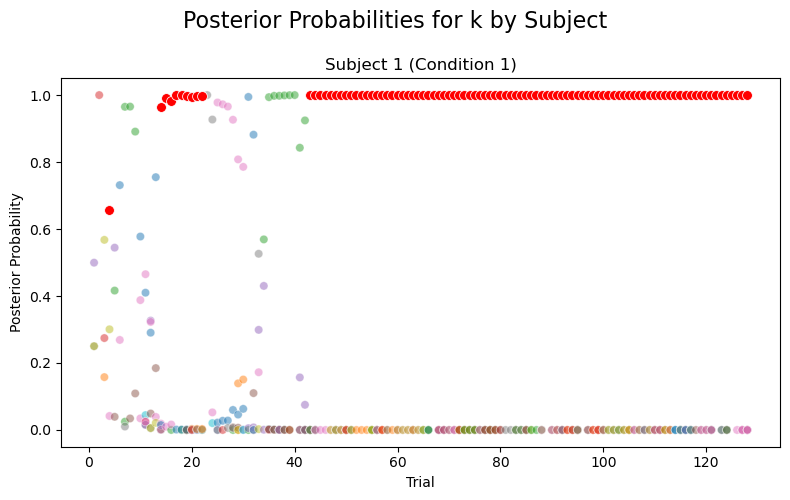

In [32]:
model_eval.plot_posterior_probabilities(results, [iSub])

In [33]:
optimizer.set_results(results)
prediction = optimizer.predict_with_subs_parallel(
    config_fgt, [iSub])

Predicting tasks: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 1627.59it/s]

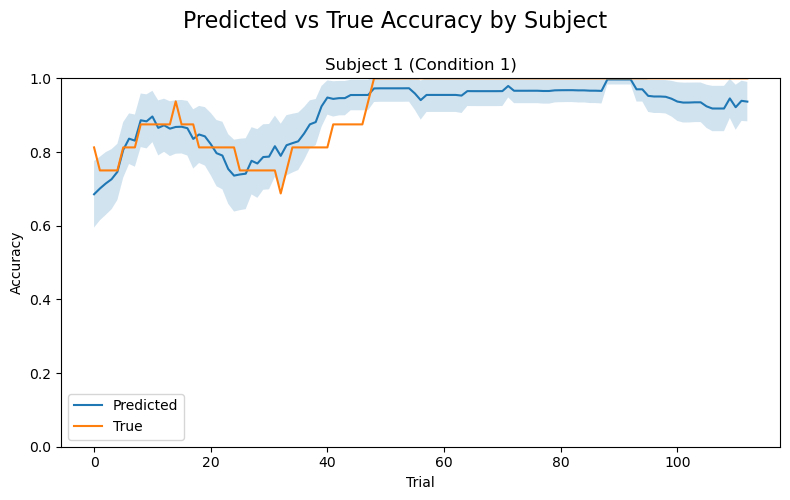

In [34]:
model_eval.plot_accuracy_comparison(prediction, [iSub])

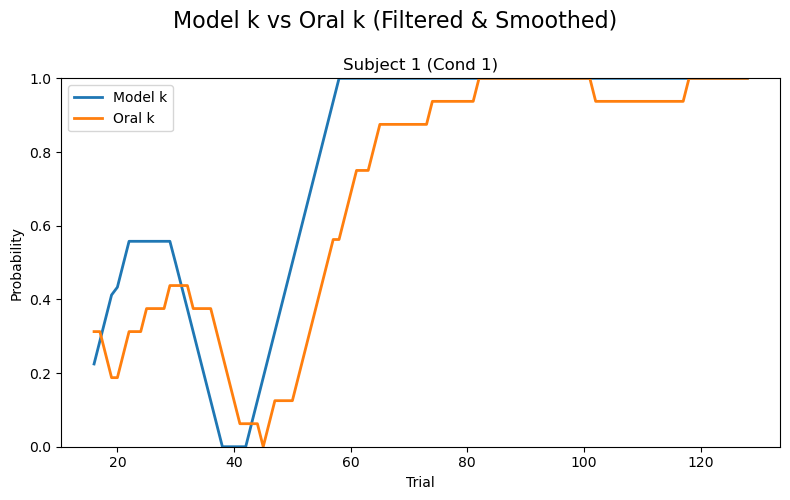

In [35]:
model_eval.plot_k_oral_comparison(
    results, oral_hypo_hits, [iSub])

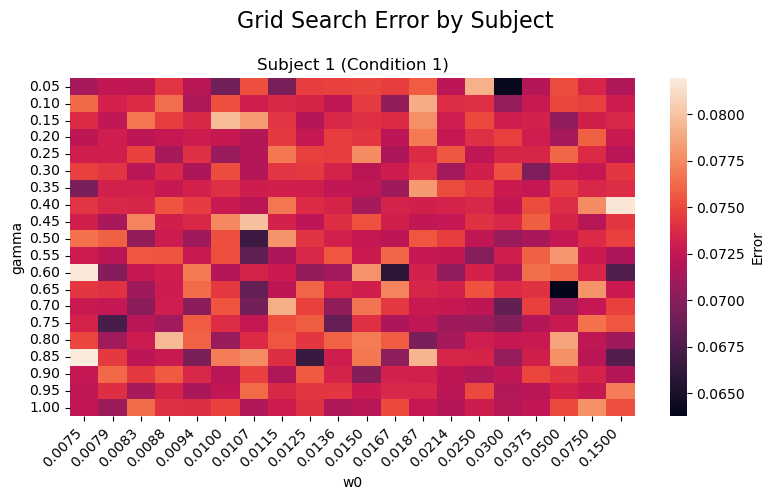

In [36]:
model_eval.plot_error_grids(results, fname=['gamma','w0'])

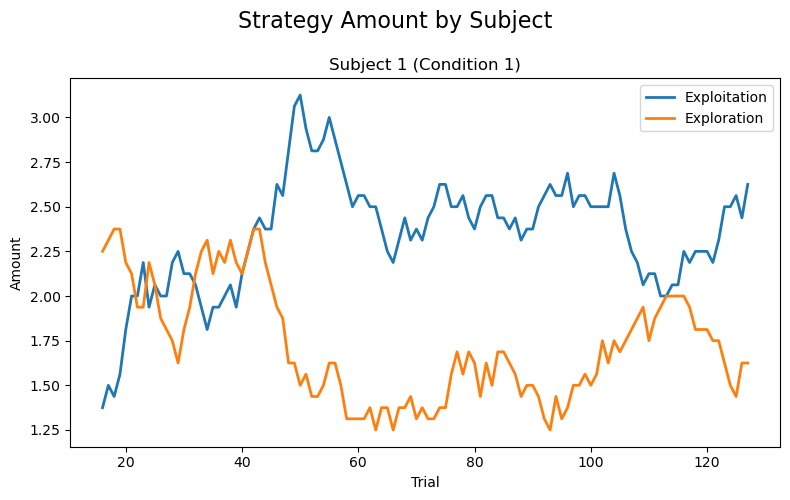

In [37]:
model_eval.plot_cluster_amount(results, 16, [iSub])

#### plot

In [24]:
model_name = "M2_M"
# model_name = "M7_PMH"

In [25]:
# 加载拟合结果
result_path = Path(project_root) / 'results' / 'Model_results'
results = joblib.load(result_path / f'{model_name}.joblib')

In [26]:
from src.Bayesian_recon.utils.model_evaluation import ModelEval
model_eval = ModelEval()

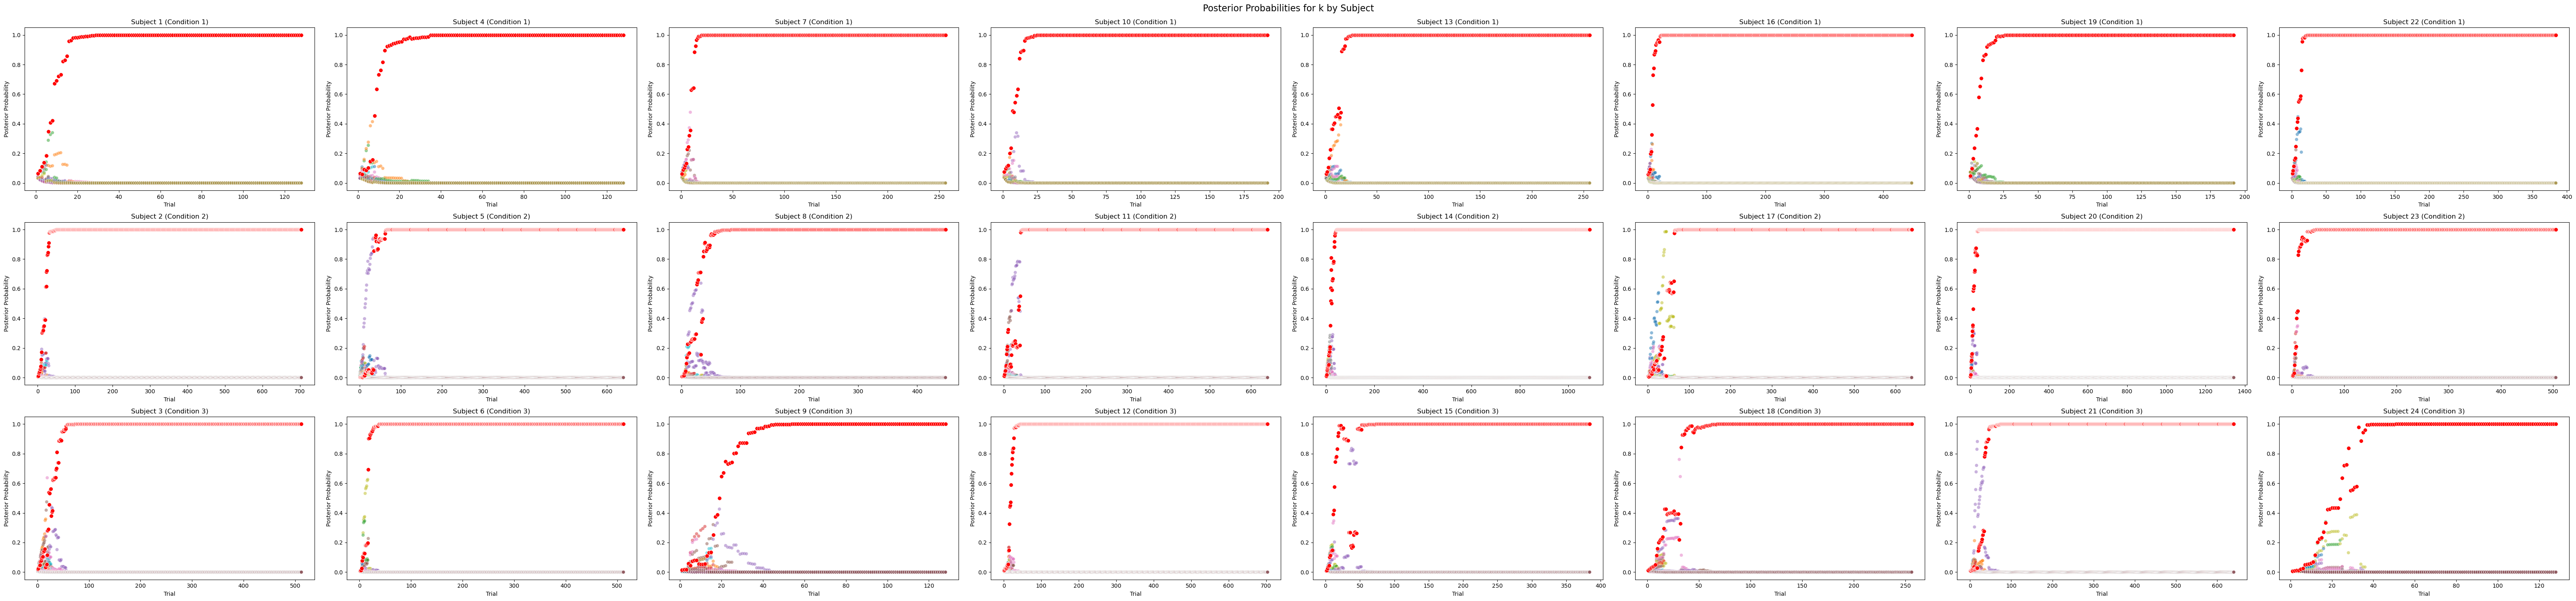

In [27]:
model_eval.plot_posterior_probabilities(
    results, save_path=result_path/f'{model_name}_post.png')

In [28]:
optimizer.set_results(results)
prediction = optimizer.predict_with_subs_parallel(
    config_fgt, range(1,25))

Predicting tasks: 100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 29305.18it/s]


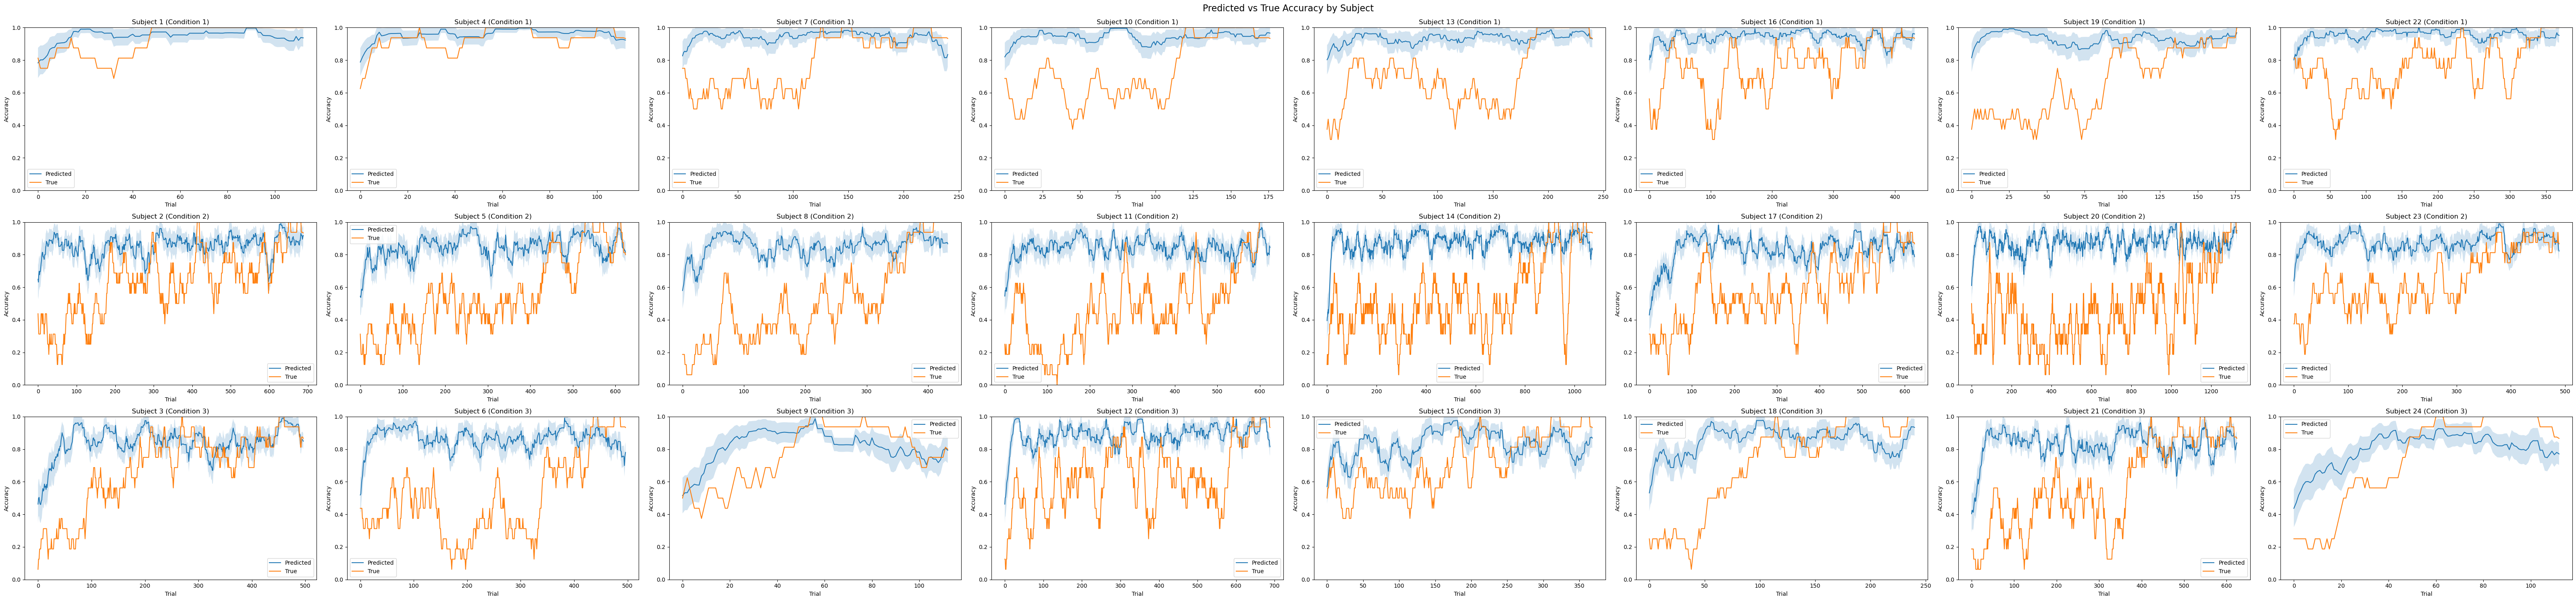

In [29]:
model_eval.plot_accuracy_comparison(prediction, save_path=result_path/f'{model_name}_acc.png')

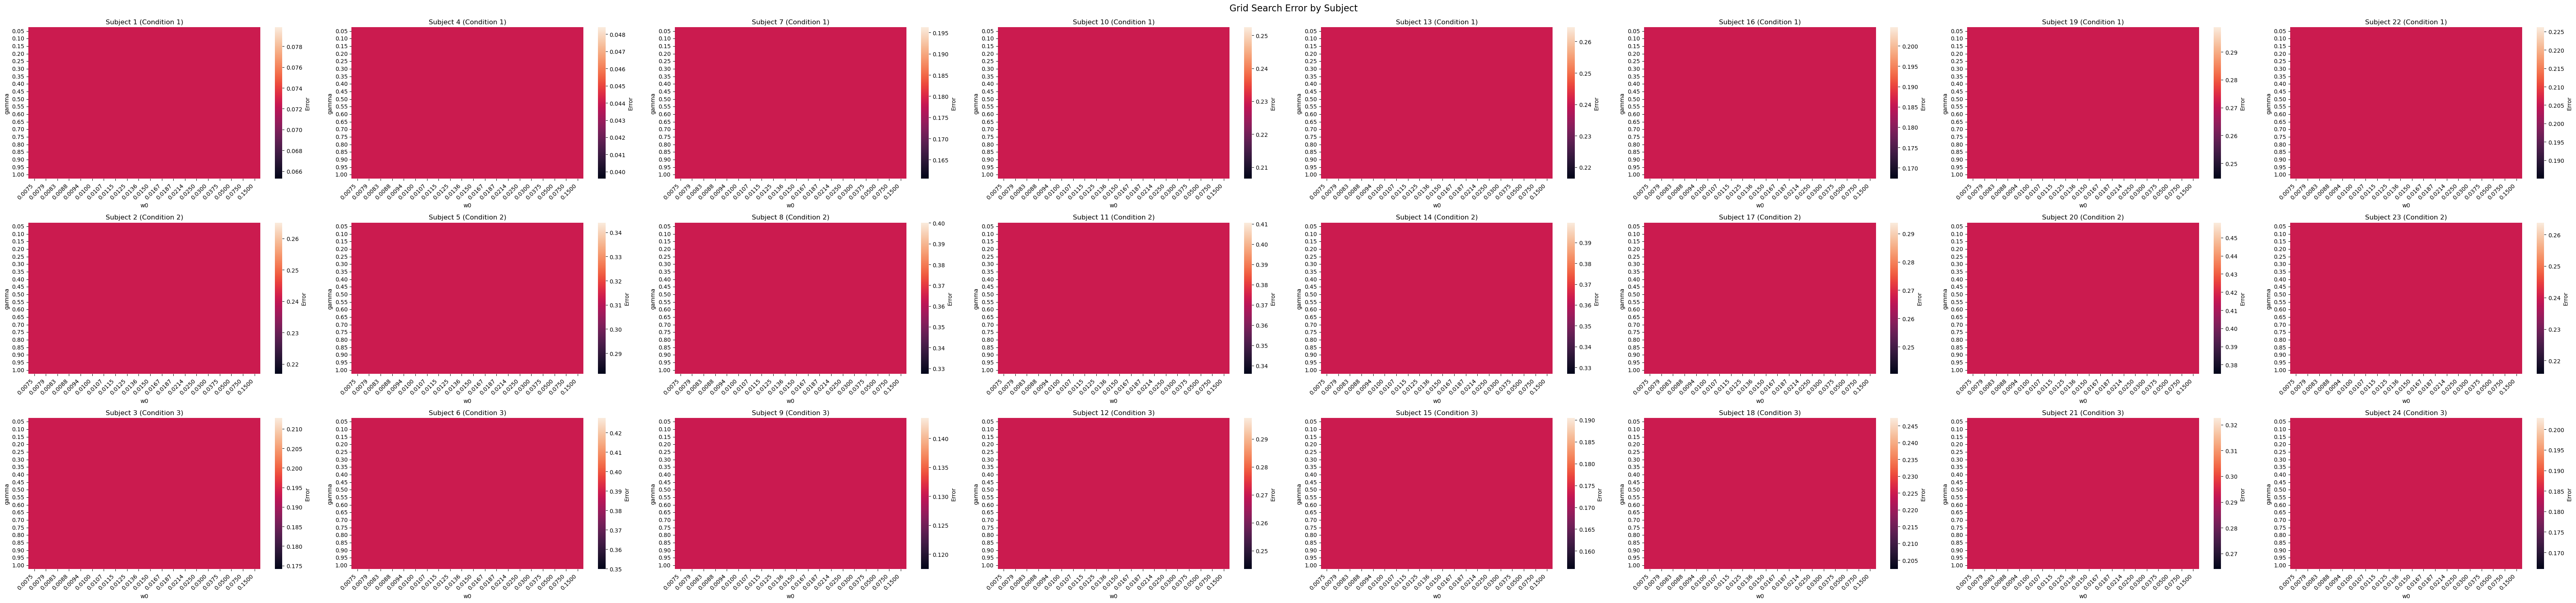

In [30]:
model_eval.plot_error_grids(results, fname=['gamma','w0'], save_path=result_path/f'{model_name}_grid.png')

In [22]:
oral_hypo_hits = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'oral_hypo_hits.joblib')

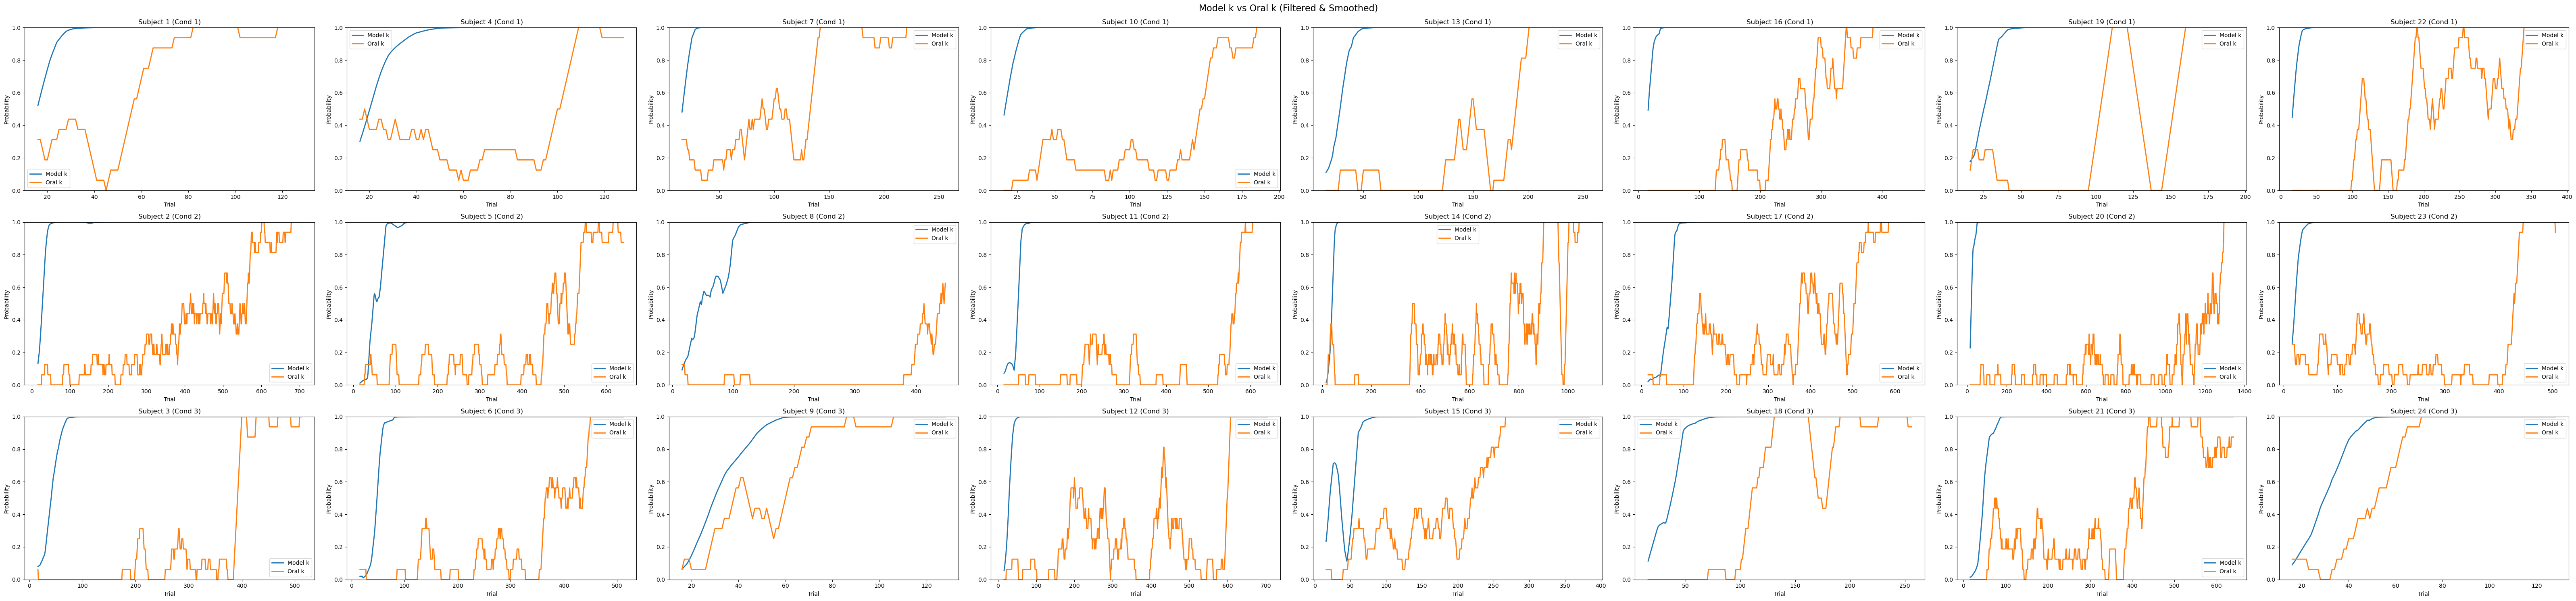

In [23]:
model_eval.plot_k_oral_comparison(
    results, oral_hypo_hits,
    range(1,25), save_path=result_path/f'{model_name}_oral.png')

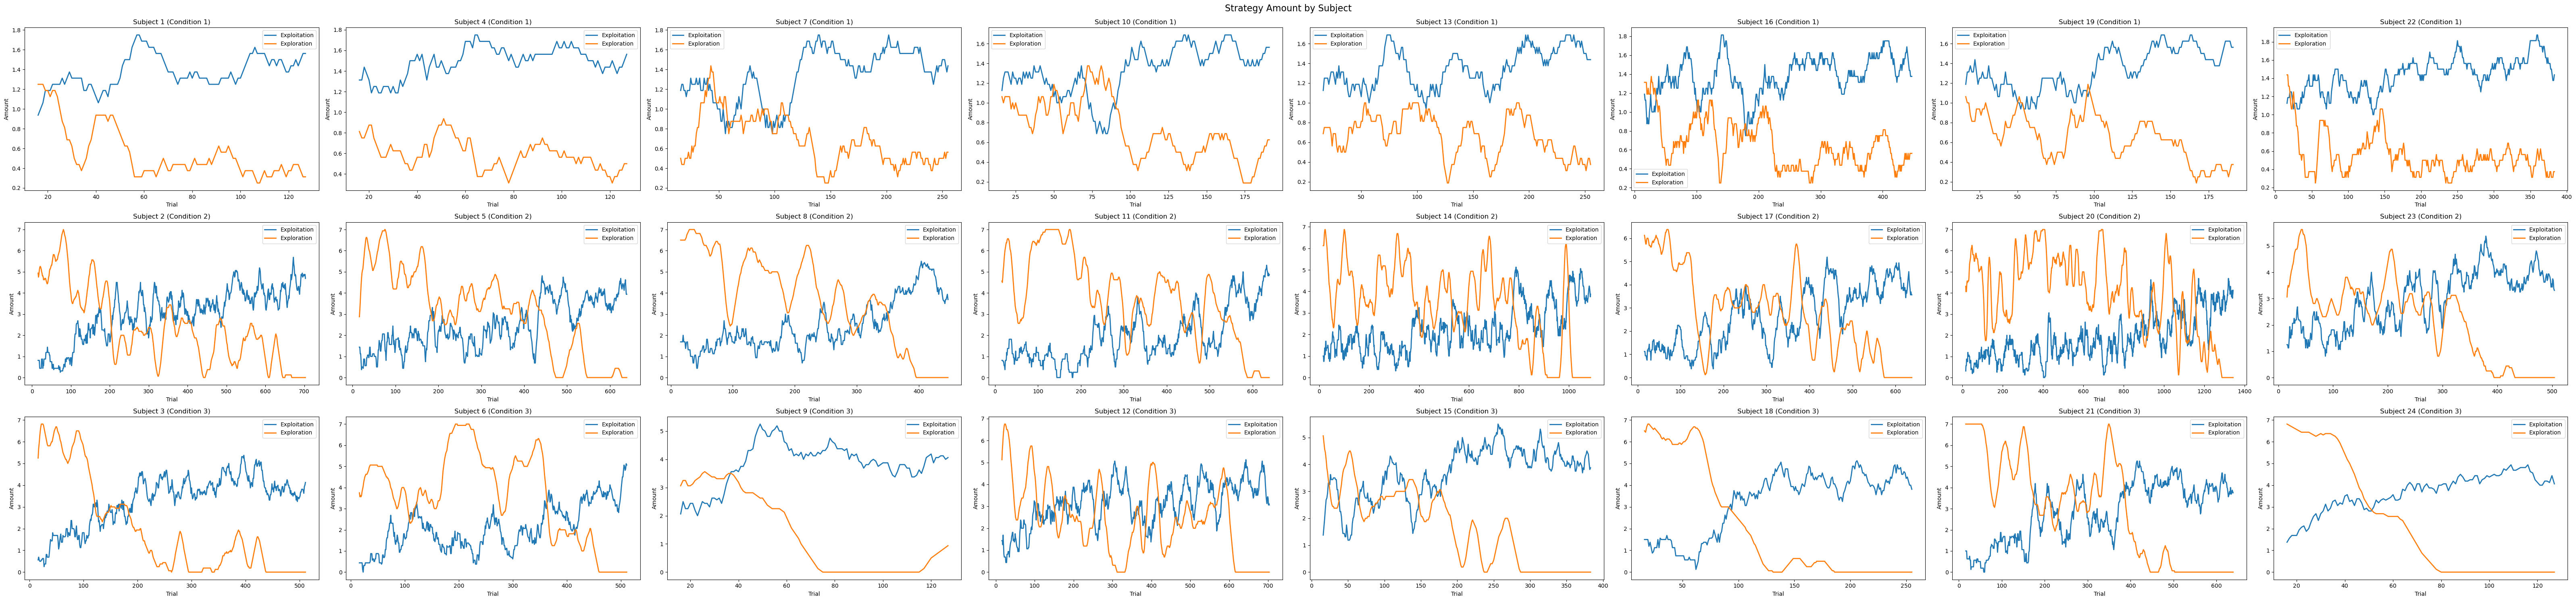

In [46]:
model_eval.plot_cluster_amount(results, window_size=16, save_path=result_path/f'{model_name}_amount.png')

####  q

In [ ]:
from pathlib import Path
import joblib

# 获取所有带有指定前缀的文件
files_to_merge = list(result_path.glob("M_fgt_cl_*.joblib"))

# 合并文件内容
merged_data = {}
for file in files_to_merge:
    data = joblib.load(file)
    merged_data.update(data)

# 保存合并后的文件
output_file = result_path / "M_fgt_cl.joblib"
joblib.dump(merged_data, output_file)

print(f"Merged file saved to {output_file}")